In [1]:
import torch 
from sbi.analysis import pairplot

import matplotlib.pyplot as plt

from rbi.utils.datasets import get_datasets, get_reference_simulator
from rbi.utils.nets import MixtureDiagGaussianModel, MultivariateGaussianNet
from rbi.loss.loss_fn import NLLLoss

In [3]:
t_max = 20
time_points_observed = 100

train_loader, test_loader = get_datasets("lotka_volterra_inverse", time_points_observed=time_points_observed, t_max=t_max, N_train=10000, N_test=20000, batch_size=10000)
ref_simulator = get_reference_simulator("lotka_volterra", time_points_observed = time_points_observed, t_max=t_max)

IndexError: too many indices for tensor of dimension 1

In [2]:
net = MultivariateGaussianNet(5, 4, hidden_dims=[500, 500, 500], nonlinearity=torch.nn.Tanh)
loss_fn = NLLLoss(net)

In [3]:
from rbi.utils.fisher_info import compute_reparameterized_fisher, monte_carlo_diagonal_fisher

In [4]:
x = torch.ones(10, 5)

In [5]:
F = compute_reparameterized_fisher(net, x, net(x), mc_samples=1000)

In [7]:
eigenvalues, eigenvectors = torch.linalg.eigh(F)

In [13]:
eigenvalues[:, -1]

tensor([0.0564, 0.0575, 0.0515, 0.0553, 0.0622, 0.0568, 0.0562, 0.0620, 0.0563,
        0.0589], grad_fn=<SelectBackward0>)

In [11]:
eigenvectors[:, :, -1]

tensor([[ 0.1235, -0.5683,  0.4247,  0.5074, -0.4733],
        [ 0.1858, -0.5133,  0.4198,  0.4576, -0.5624],
        [ 0.1198, -0.4641,  0.4314,  0.5089, -0.5703],
        [ 0.1379, -0.5272,  0.4243,  0.4822, -0.5389],
        [ 0.0449, -0.5399,  0.4493,  0.5997, -0.3808],
        [ 0.1097,  0.6084, -0.4513, -0.6417,  0.0487],
        [ 0.1144, -0.5567,  0.4311,  0.5359, -0.4515],
        [ 0.0652, -0.5122,  0.4426,  0.5652, -0.4671],
        [ 0.0309,  0.5799, -0.4838, -0.6182,  0.2156],
        [ 0.0893, -0.5414,  0.4435,  0.5649, -0.4279]],
       grad_fn=<SelectBackward0>)

In [68]:
def func(x):
    q = net(x)
    return q.log_prob(q.sample((1000,))).mean()

def batch_hessian(func, x):
    Hs = []
    for i in range(x.shape[0]):
        Hs.append(torch.autograd.functional.hessian(func, x[i], vectorize=True))
    return torch.stack(Hs)

In [69]:
%%timeit
batch_hessian(func, x).var()

165 ms ± 5.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [75]:
def func(*args):
    x = torch.vstack(args)
    q = net(x)
    return q.log_prob(q.sample((1000,))).mean()

def batch_hessian(func, x):
    return torch.autograd.functional.hessian(func, x.split(1, dim=0), vectorize=True)

In [76]:
batch_hessian(func, x)

((tensor([[[[-3.4304e-03,  1.1601e-03, -6.0289e-04,  5.8509e-04,  5.3077e-04]],
  
           [[ 1.1601e-03, -3.2003e-03,  7.7438e-04, -1.8392e-03,  7.2161e-05]],
  
           [[-6.0288e-04,  7.7438e-04, -1.7115e-03,  5.8741e-04,  8.8060e-04]],
  
           [[ 5.8510e-04, -1.8392e-03,  5.8741e-04, -3.0899e-03,  1.0417e-03]],
  
           [[ 5.3077e-04,  7.2161e-05,  8.8060e-04,  1.0417e-03, -2.1820e-03]]]]),
  tensor([[[[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]]]]),
  tensor([[[[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]]]]),
  tensor([[[[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]],
  
           [[0., 0., 0., 0., 0.]]]]),
  tensor([[[[0.

In [73]:
%%timeit
batch_hessian(func, x).var()

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [48]:
F_hessian_based.transpose(1, 2).shape

torch.Size([10, 10, 5, 5])

In [62]:
F.var()

tensor(0.0002, grad_fn=<VarBackward0>)

In [178]:
def power_iterations(F, iters=10):
    b_k = torch.randn(F.shape[0], F.shape[-1])
    for i in range(iters):
        b_k1 = torch.einsum("bij, bj -> bi", F, b_k)
        b_k1_norm = torch.linalg.norm(b_k1, dim=-1, keepdim=True)
        b_k = b_k1 / b_k1_norm
    return b_k, (torch.einsum("bij, bj -> bi", F, b_k)/b_k).mean()

In [179]:
net

MultivariateGaussianNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=500, bias=True)
    (1): Tanh()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): Tanh()
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): Tanh()
    (6): Linear(in_features=500, out_features=14, bias=True)
    (7): Identity()
  )
  (embedding_net): Identity()
)

In [180]:
optim = torch.optim.Adam(net.parameters())

for i in range(1000):
    optim.zero_grad()
    F = compute_reparameterized_fisher(net, x, net(x), mc_samples=1000)
    _, l = power_iterations(F)
    l.backward()
    optim.step()
    print(l)


tensor(0.0656, grad_fn=<MeanBackward0>)
tensor(4.1160, grad_fn=<MeanBackward0>)
tensor(0.4424, grad_fn=<MeanBackward0>)
tensor(0.5327, grad_fn=<MeanBackward0>)
tensor(0.3795, grad_fn=<MeanBackward0>)
tensor(0.2948, grad_fn=<MeanBackward0>)
tensor(0.3364, grad_fn=<MeanBackward0>)
tensor(0.2593, grad_fn=<MeanBackward0>)
tensor(0.1876, grad_fn=<MeanBackward0>)
tensor(0.1631, grad_fn=<MeanBackward0>)
tensor(0.3224, grad_fn=<MeanBackward0>)
tensor(0.1557, grad_fn=<MeanBackward0>)
tensor(0.1314, grad_fn=<MeanBackward0>)
tensor(0.1083, grad_fn=<MeanBackward0>)
tensor(0.0814, grad_fn=<MeanBackward0>)
tensor(0.1074, grad_fn=<MeanBackward0>)
tensor(0.1093, grad_fn=<MeanBackward0>)
tensor(0.3372, grad_fn=<MeanBackward0>)
tensor(0.3981, grad_fn=<MeanBackward0>)
tensor(0.2237, grad_fn=<MeanBackward0>)
tensor(1.4801, grad_fn=<MeanBackward0>)
tensor(3.0272, grad_fn=<MeanBackward0>)
tensor(3.2999, grad_fn=<MeanBackward0>)
tensor(2.2329, grad_fn=<MeanBackward0>)
tensor(1.0508, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [169]:
power_iterations(F, iters=100)

(tensor([[ 0.3652,  0.6817, -0.2585,  0.1146,  0.5674]], grad_fn=<DivBackward0>),
 tensor(0.0314, grad_fn=<MeanBackward0>))

In [73]:
torch.linalg.eigh(F)

torch.return_types.linalg_eigh(
eigenvalues=tensor([[0.0007, 0.0051, 0.0109, 0.0225, 0.0314]],
       grad_fn=<LinalgEighBackward0>),
eigenvectors=tensor([[[ 0.1553,  0.8212, -0.3470, -0.2185, -0.3652],
         [ 0.3793, -0.1993,  0.5521, -0.2166, -0.6817],
         [-0.0105,  0.5226,  0.6858,  0.4355,  0.2585],
         [-0.8225,  0.0896,  0.2673, -0.4804, -0.1146],
         [-0.3942, -0.0693, -0.1816,  0.6963, -0.5674]]],
       grad_fn=<LinalgEighBackward0>))

In [100]:

xs = net(x).sample((10,))

torch.Size([10, 1, 4])

In [101]:
parameters = x.repeat(xs.shape[0],1, 1)

In [1]:
from rbi.attacks.advertorch_attack import L2PGDAttack

In [140]:
from rbi.utils.fisher_info import score_function

scores = score_function(net(x).sample((5000,)), x, net)

In [155]:
 torch.linalg.eigh((scores.transpose(-2, -1) @ scores).mean(0) ).eigenvectors[:, -1]


tensor([-0.3277, -0.6031,  0.1306, -0.0068, -0.7154],
       grad_fn=<SelectBackward0>)

In [164]:
def mc_power_iterations(scores, iters=1000):
    scores = scores.reshape(scores.shape[0], scores.shape[-1])
    b_k = torch.randn(scores.shape[0], scores.shape[-1])
    for i in range(iters):
        scal = torch.einsum("bj, bj -> b", scores, b_k)
        b_k1 = (scores * scal.unsqueeze(-1)).mean(0, keepdim=True)
        b_k1_norm = torch.linalg.norm(b_k1, dim=-1, keepdim=True)
        b_k = b_k1 / b_k1_norm
        if torch.linalg.norm(b_k)
    return b_k

In [165]:
mc_power_iterations(scores)

tensor([[-0.3277, -0.6031,  0.1306, -0.0068, -0.7154]], grad_fn=<DivBackward0>)

In [19]:
optim = torch.optim.Adam(net.parameters(), lr=1e-4)

for i in range(20):
    for X,Y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X,Y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 10.)
        optim.step()
    print(loss)

tensor(-3.1106, grad_fn=<AddBackward0>)
tensor(1.6000, grad_fn=<AddBackward0>)
tensor(-2.8400, grad_fn=<AddBackward0>)
tensor(-2.1305, grad_fn=<AddBackward0>)
tensor(-1.5897, grad_fn=<AddBackward0>)
tensor(-1.5481, grad_fn=<AddBackward0>)
tensor(-1.6906, grad_fn=<AddBackward0>)
tensor(-1.9408, grad_fn=<AddBackward0>)
tensor(-2.2217, grad_fn=<AddBackward0>)
tensor(-2.4524, grad_fn=<AddBackward0>)
tensor(-2.5762, grad_fn=<AddBackward0>)
tensor(-2.5744, grad_fn=<AddBackward0>)
tensor(-2.4811, grad_fn=<AddBackward0>)
tensor(-2.3812, grad_fn=<AddBackward0>)
tensor(-2.3607, grad_fn=<AddBackward0>)
tensor(-2.4442, grad_fn=<AddBackward0>)
tensor(-2.5813, grad_fn=<AddBackward0>)
tensor(-2.6960, grad_fn=<AddBackward0>)
tensor(-2.7473, grad_fn=<AddBackward0>)
tensor(-2.7528, grad_fn=<AddBackward0>)


In [20]:
param = torch.randn(1,4).mul(0.3).exp()
x_obs = ref_simulator(param, t_max, time_points_observed)


In [21]:
post_est = net(x_obs.reshape(1, -1))

In [22]:
samples = post_est.sample((1,1000)).reshape(-1,4)[::2]

(<Figure size 720x720 with 16 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 4'>]], dtype=object))

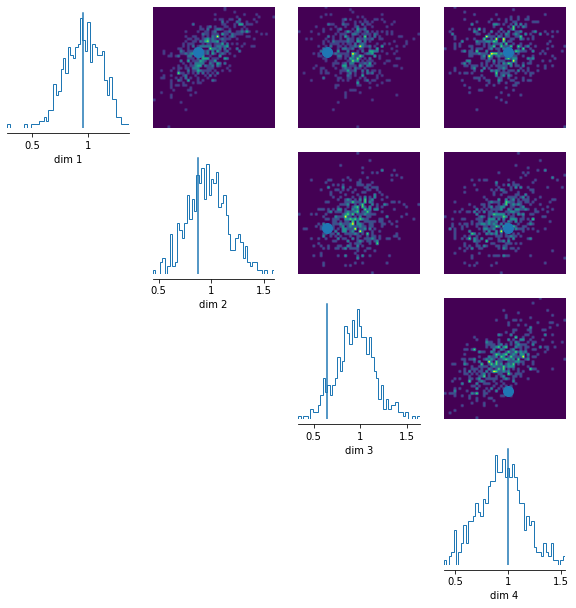

In [23]:
pairplot(samples, points=param)

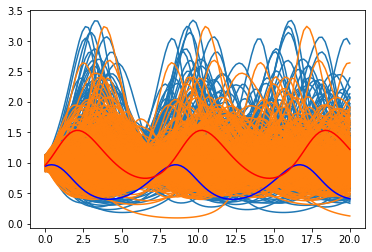

In [24]:
sols = ref_simulator(samples, t_max ,time_points_observed)
plt.plot(torch.linspace(0,t_max, time_points_observed),sols[:,:,0], color="C0")
_ = plt.plot(torch.linspace(0,t_max, time_points_observed),sols[:,:,1], color="C1")

plt.plot(torch.linspace(0,t_max, time_points_observed), x_obs[:,:,0].detach(), color="blue")
plt.plot(torch.linspace(0,t_max, time_points_observed), x_obs[:,:,1].detach(), color="red")

In [95]:
from rbi.attacks.advertorch_attack import LinfPGDAttack, LinfMomentumIterativeAttack
from rbi.attacks.custom_attacks import WhiteNoiseAttack
from rbi.metrics.empirical_metrics import EmpiricalAdversarialTestLossMetric
from rbi.metrics.empirical_metrics import EmpiricalApproximationfKL
from rbi.loss.loss_fn import LogLikelihoodLoss, ForwardKLLoss, NegativeLogLikelihoodLoss

from rbi.visualization.robustness_eval_plots import plot_metric_for_pertubation_scales

In [101]:
adversarial_loss = ForwardKLLoss()
test_loss = NegativeLogLikelihoodLoss()
adversarial_loss2 = LogLikelihoodLoss()

In [102]:
attack1 = LinfMomentumIterativeAttack(net, loss_fn=adversarial_loss, eps=0.2,eps_iter=0.1, nb_iter=500, targeted=False)
attack2 = WhiteNoiseAttack()

In [103]:
#attack1 = LinfMomentumIterativeAttack(net, loss_fn=adversarial_loss2, eps=0.2,eps_iter=0.1, nb_iter=500, targeted=True)

In [120]:
for X, param in test_loader:
    X_perturbed = attack1.perturb(X)
    break

In [121]:
sort_attacks =ForwardKLLoss(reduction=None)(net(X),net(X_perturbed)).argsort()
losses = ForwardKLLoss(reduction=None)(net(X),net(X_perturbed))

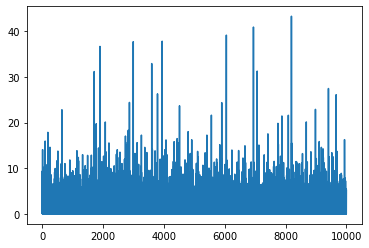

In [122]:
plt.plot(losses.detach())

In [123]:
X_perturbed = X_perturbed[sort_attacks]
X = X[sort_attacks]
param = param[sort_attacks]

In [124]:
X_perturbed = X_perturbed.reshape(-1, time_points_observed, 2).detach()
X = X.reshape(-1, time_points_observed, 2).detach()

In [125]:
index = -1

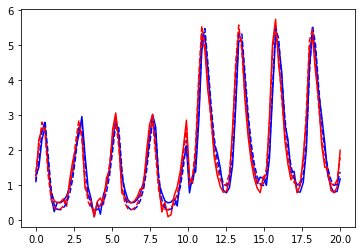

In [126]:
plt.plot(torch.linspace(0,t_max, time_points_observed), X_perturbed[index,:,0].detach(), color="blue")
plt.plot(torch.linspace(0,t_max, time_points_observed), X_perturbed[index,:,1].detach(), color="red")
plt.plot(torch.linspace(0,t_max, time_points_observed), X[index,:,0].detach(), color="blue", linestyle="--")
plt.plot(torch.linspace(0,t_max, time_points_observed), X[index,:,1].detach(), color="red", linestyle="--")

In [127]:
post_est1 = net(X[index].reshape(1,-1))
post_est2 = net(X_perturbed[index].reshape(1,-1))

c:\ProgramData\Miniconda3\lib\site-packages\sbi\utils\plot.py:348: UserWarning: No contour levels were found within the data range.
  h = plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\utils\plot.py:348: UserWarning: No contour levels were found within the data range.
  h = plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\utils\plot.py:348: UserWarning: No contour levels were found within the data range.
  h = plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\utils\plot.py:348: UserWarning: No contour levels were found within the data range.
  h = plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\utils\plot.py:348: UserWarning: No contour levels were found within the data range.
  h = plt.contour(
c:\ProgramData\Miniconda3\lib\site-packages\sbi\utils\plot.py:348: UserWarning: No contour levels were found within the data range.
  h = plt.contour(


(<Figure size 720x720 with 16 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 4'>]], dtype=object))

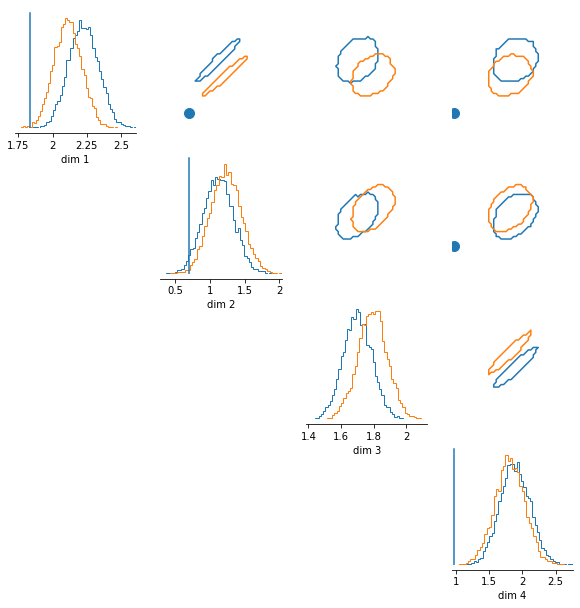

In [128]:
samples1 = post_est1.sample((10000,)).squeeze()
samples2 = post_est2.sample((10000,)).squeeze()

pairplot([samples1, samples2], upper="contour", points=param[index])

In [129]:
from rbi.defenses.regularized_loss import GaussianNoiseJacobiRegularizer

defense = GaussianNoiseJacobiRegularizer(net, loss_fn, 0.1)
F = defense._compute_fisher(X.reshape(-1, 200), net(X.reshape(-1, 200))).squeeze().detach()
F_pert = defense._compute_fisher(X_perturbed.reshape(-1, 200), net(X_perturbed.reshape(-1, 200))).squeeze().detach()

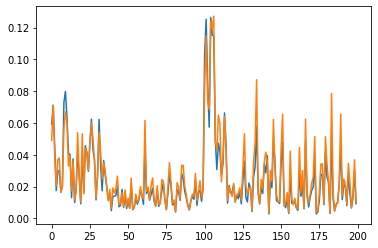

In [130]:
plt.plot(torch.diagonal(F, dim1=-2, dim2=-1).mean(0))
plt.plot(torch.diagonal(F_pert, dim1=-2, dim2=-1).mean(0))

(0.0, 50.0)

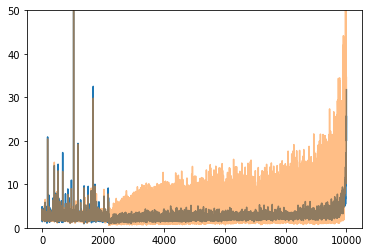

In [131]:
plt.plot(torch.linalg.eigvalsh(F).max(-1).values)
plt.plot(torch.linalg.eigvalsh(F_pert).max(-1).values, alpha=0.5)
plt.ylim(0,50)

In [69]:
defense = GaussianNoiseJacobiRegularizer(net, loss_fn, 0.1)
F = defense._compute_fisher(X.reshape(-1, 200)[-100:], net(X.reshape(-1, 200)[-100:])).squeeze().detach()
F_pert = defense._compute_fisher(X_perturbed.reshape(-1, 200)[-100:], net(X_perturbed.reshape(-1, 200)[-100:])).squeeze().detach()

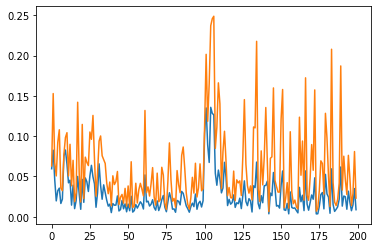

In [70]:
plt.plot(torch.diagonal(F, dim1=-2, dim2=-1).mean(0))
plt.plot(torch.diagonal(F_pert, dim1=-2, dim2=-1).mean(0))

In [287]:
m1 = EmpiricalAdversarialTestLossMetric(net, attack1, test_loss)
m2 = EmpiricalAdversarialTestLossMetric(net, attack2, test_loss)

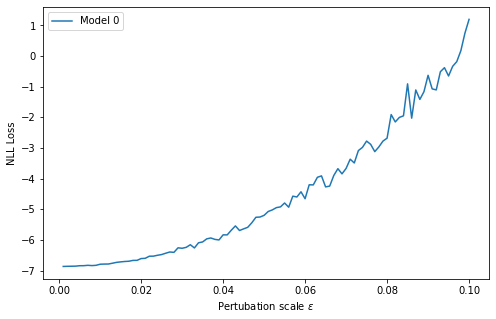

In [110]:
fig = plot_metric_for_pertubation_scales(torch.linspace(0.001, 0.1, 100), [m2], test_loader)

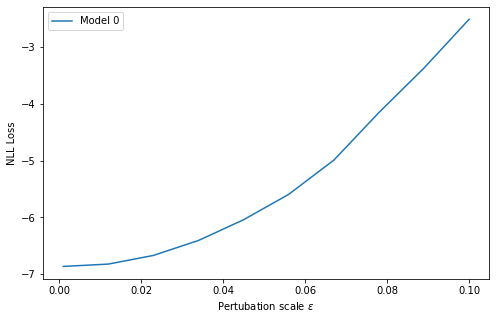

In [114]:
fig = plot_metric_for_pertubation_scales(torch.linspace(0.001, 0.1, 10), [m1], test_loader)

In [249]:
attack1.eps=0.3
attack1.nb_iter=1000
attack1.eps_iter = 1e-2
x_perturbed = attack1.perturb(x_obs.reshape(1, -1))

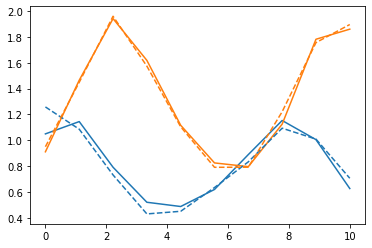

In [250]:
plt.plot(torch.linspace(0,10, 10),x_obs[:,:,0])
plt.plot(torch.linspace(0,10, 10),x_obs[:,:,1])

plt.plot(torch.linspace(0,10, 10),x_perturbed.reshape(x_obs.shape)[:,:,0], color="C0", linestyle="dashed")
plt.plot(torch.linspace(0,10, 10),x_perturbed.reshape(x_obs.shape)[:,:,1], color="C1", linestyle="dashed")

In [251]:
post_est = net(x_perturbed)

In [253]:
samples1 = post_est.sample((1,1000)).reshape(-1,4)[::2]

(<Figure size 720x720 with 16 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='dim 3'>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='dim 4'>]], dtype=object))

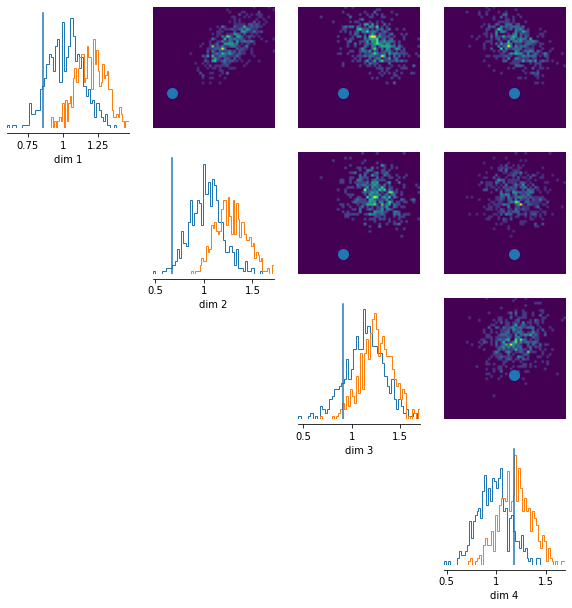

In [254]:
pairplot([samples, samples1], points=param)

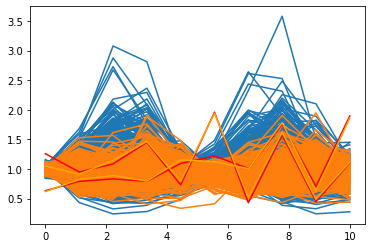

In [274]:
sols = ref_simulator(samples1, 10, 10)
plt.plot(torch.linspace(0,10, 10),sols[:,:,0], color="C0")
_ = plt.plot(torch.linspace(0,10, 10),sols[:,:,1], color="C1")
plt.plot(torch.linspace(0,10, 10), x_perturbed[0,:10].detach(), color="red")
plt.plot(torch.linspace(0,10, 10), x_perturbed[0,10:].detach(), color="red")

plt.plot(torch.linspace(0,10, 10), x_obs.reshape(-1,20)[0,:10].detach(), color="orange")
plt.plot(torch.linspace(0,10, 10), x_obs.reshape(-1,20)[0,10:].detach(), color="orange")